# PS 5: Kernels

**Your Name:** Gino Rospigliosi

**People I discussed this question with:** None

For this problem, you will study the effects of different kernel functions on how they affect model performance and assumptions.

To set up the problem, we will load some time-series data that we saw in class on modeling CO2 concentration:

In [109]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_openml
from datetime import datetime, timedelta
import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
sns.set_context('notebook')

# Fetch the data 
mauna_lao = fetch_openml('mauna-loa-atmospheric-co2')
print(mauna_lao.DESCR)
data = mauna_lao.data
# Assemble the day/time from the data columns so we can plot it
d1958 = datetime(year=1958,month=1,day=1)
time = [datetime(int(d[0]),int(d[1]),int(d[2])) for d in data] 
X = np.array([1958+(t-d1958)/timedelta(days=365.2425) for t in time]).T
X = X.reshape(-1,1)  # Make it a column to make scikit happy
# Shift it so that the middle of the prediction is zero:
X -= X.mean()  
y = np.array(mauna_lao.target)
y -= y.mean()

**Weekly carbon-dioxide concentration averages derived from continuous air samples for the Mauna Loa Observatory, Hawaii, U.S.A.**<br><br>
These weekly averages are ultimately based on measurements of 4 air samples per hour taken atop intake lines on several towers during steady periods of CO2 concentration of not less than 6 hours per day; if no such periods are available on a given day, then no data are used for that day. The _Weight_ column gives the number of days used in each weekly average. _Flag_ codes are explained in the NDP writeup, available electronically from the [home page](http://cdiac.ess-dive.lbl.gov/ftp/trends/co2/sio-keel-flask/maunaloa_c.dat) of this data set. CO2 concentrations are in terms of the 1999 calibration scale (Keeling et al., 2002) available electronically from the references in the NDP writeup which can be accessed from the home page of this data set.
<br><br>
### Feature Descriptions
_co2_: average co2 concentration in ppvm <br>
_year_: year of concent

Now we will split this data into a training set in the middle of dat

In [110]:
# Split the Data into training and testing for comparison sake
#len(X)
cut_ind = round(len(X)*.5)
train_ind = range(cut_ind,len(X)-cut_ind)
X_train = X[0:cut_ind]
X_test  = X[cut_ind:]
y_train = y[0:cut_ind]
y_test  = y[cut_ind:]

#train_ind = range(cut_ind,len(X)-cut_ind)
#test_ind = list(range(cut_ind))+list(range(len(X)-cut_ind,len(X)))
#X_train = X[train_ind]
#X_test  = X[test_ind]
#y_train = y[train_ind]
#y_test  = y[test_ind]

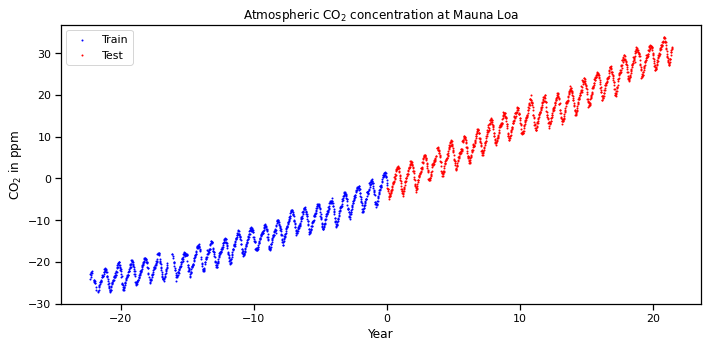

In [111]:
# Plot the data
plt.figure(figsize=(10,5))    # Initialize empty figure
plt.scatter(X_train, y_train, c='b',
            s=1, label = 'Train') # Scatterplot of data
plt.scatter(X_test, y_test, c='r',
            s=1, label = 'Test') # Scatterplot of data
plt.xlabel("Year")
plt.ylabel(r"CO$_2$ in ppm")
plt.title(r"Atmospheric CO$_2$ concentration at Mauna Loa")
plt.legend()
plt.tight_layout()
plt.show()

In [112]:
# Helper code to perform the plotting for you later if you want it.
# You don't need to modify this cell or even use it if you don't want to.
from textwrap import wrap
def plot_CO2_data(X,y,X_p,y_p,label=''):
    plt.figure(figsize=(10,5))
    # Plot Original Data
    plt.scatter(X, y, s=10, marker='o', linewidths=1,
                edgecolors='k', facecolors='none',
                label='Data')
    plt.plot(X_p,y_p,alpha=1,lw=2,label='Prediction')
    title_str = "\n".join(wrap(str(label), 60))
    plt.title("Kernel: "+str(title_str))
    plt.xlim([min(X_p),max(X_p)])
    plt.xlabel("Year")
    plt.ylabel("$CO^2$")
    plt.legend()
    plt.show()

Then we will go ahead and load various [kernels available via Scikit Learn](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.gaussian_process). For example:

* [White Kernel](https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.kernels.WhiteKernel.html#sklearn.gaussian_process.kernels.WhiteKernel) for modeling noise
* [ExpSineSquared Kernel](https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.kernels.ExpSineSquared.html#sklearn.gaussian_process.kernels.ExpSineSquared) for modeling periodic functions
* [RBF Kernels](https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.kernels.RBF.html#sklearn.gaussian_process.kernels.RBF) for smoothly varying functions
* [Dot Product Kernels](https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.kernels.DotProduct.html) for linear functions.
* [Matern Kernels](https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.kernels.Matern.html#sklearn.gaussian_process.kernels.Matern) for smoothly varying functions with controllable degrees of continuity in their derivatives
* [Constant Kernels](https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.kernels.ConstantKernel.html#sklearn.gaussian_process.kernels.ConstantKernel) for constant functions
* [Rational Quadratic kernels](https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.kernels.RationalQuadratic.html#sklearn.gaussian_process.kernels.RationalQuadratic) for mixtures of RBF kernels with different length scales

With any of these kernels you can add them, multiply them, exponentiate them to create new, more complex kernels that embody multiple behaviors. For the below tasks, you will explore different properties of these kernels in the context of Kernel Ridge Regression.

You should be able to complete this assignment using the below pre-loaded kernels:

In [113]:
from sklearn.kernel_ridge import KernelRidge
from sklearn.gaussian_process.kernels import WhiteKernel, ExpSineSquared, ConstantKernel 
from sklearn.gaussian_process.kernels import Matern, RBF, RationalQuadratic
from sklearn.gaussian_process.kernels import Sum, Product, Exponentiation
from sklearn.gaussian_process.kernels import DotProduct

## Task 1: Fitting the Training Data with KRR
Let's first take the training data (forgetting for a moment to test it on future data), and let's just see the effect of various modeling choices.

Specifically, your task will be to try different kernel designs and see how their behavior changes the type of function that Kernel Ridge Regression (KRR) predicts, as well as to try to capture various modeling behaviors. To start, we will reproduce the four "linear" models you used in PS2, plus add on some additional types of kernels. Please construct kernels that embody functions with the following properties and use them within KRR to do prediction. Note, all of these kernels are available as either individual or compositions of the kernels that we loaded above.

1. A linear kernel (e.g., $K(x,x)=1+\langle x_i,x_j\rangle$)
2. A quadratic kernel (e.g., $K(x,x)=(1+\langle x_i,x_j\rangle)^2$) 
3. A linear + sine kernel with an appropriate period.
4. A quadratic + sine kernel with an appropriate period.
5. An RBF Kernel (infinitely differentiable/smooth function) with a **large** bandwidth/lengthscale
6. An RBF Kernel (infinitely differentiable/smooth function) with a **small** bandwidth/lengthscale
7. A Matern Kernel with $\nu=2$ (smooth function up to 2nd derivatives)
8. A custom kernel of your own choice/design (can be a single kernel or combinations of them)

You can place these in the `kernels_to_plot` list below (like in the above example) and then use the plotting helper function below to plot the function:

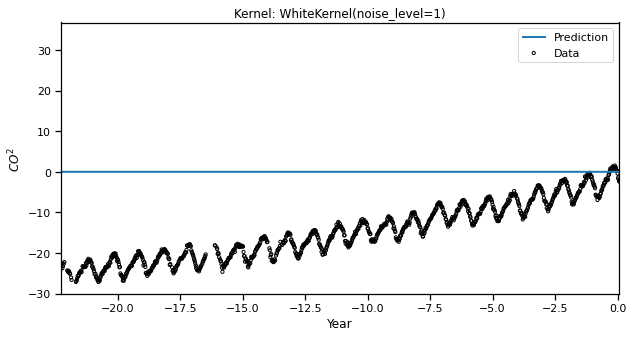

In [114]:
for kernel in kernels_to_plot:
    # Fit Kernel Ridge Regression using the kernels you identified above
    # You can change the default KRR settings below using the parameters listed
    # in the help function above, if you so desire.
    kr = KernelRidge(alpha = 1e-8,
                     kernel= kernel) 
    
    kr.fit(X_train, y_train)
    X_predict = np.linspace(X_train.min(),
                         X_train.max(), 10000)[:, None]
    y_predict = kr.predict(X_predict)
    
    # Now extrapolate 30 years into the future and past:
    #plot_CO2_data(X_train,y_train,
    plot_CO2_data(X,y,
                  X_predict, y_predict,
                  label = kr.kernel)

## Question 1:
For each of the kernels described above, please answer: Does the kernel seem to fit the data well? Why or why not?

### 1. A Linear kernel 

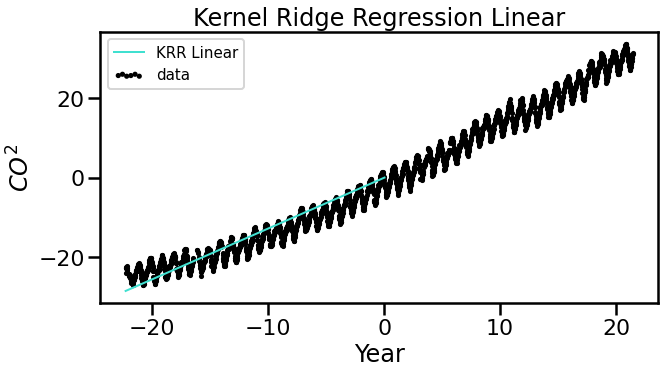

In [115]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.kernel_ridge import KernelRidge
sns.set_context('poster')

kr = KernelRidge(alpha = 1e-4,
                 gamma = 1e2,
                 kernel= "linear") 

kr.fit(X_train, y_train)

# Predict using kernel ridge on training data
y_kr = kr.predict(X_train)
      
# Plot results
plt.figure(figsize=(10, 5))
lw = 2
plt.scatter(X, y, c='k', label='data', s=10)
plt.plot(X_train, y_kr, color='turquoise', lw=lw,
         label='KRR Linear')
plt.xlabel("Year")
plt.ylabel("$CO^2$")
plt.title('Kernel Ridge Regression Linear')
plt.legend(loc="best",  scatterpoints=6, prop={'size': 15})
plt.show()

# The kernel seems to fit the data not too well. It is simplisticly linear with same outcome as linear regression where other models would be more appropriate

### 2. A quadratic kernel

C:\Users\GRosp\anaconda3-64\lib\site-packages\sklearn\linear_model\_ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.82e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True,


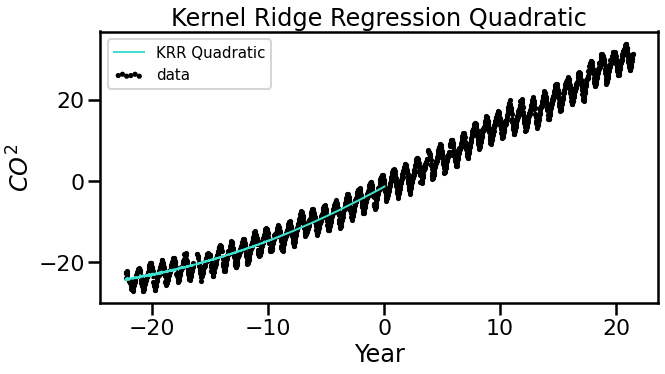

In [116]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.kernel_ridge import KernelRidge
sns.set_context('poster')

kr = KernelRidge(alpha = 1e-4,
                 degree = 2,
                 gamma = 1e2,
                 kernel= 'polynomial') 

kr.fit(X_train, y_train)

# Predict using kernel ridge on training data
y_kr = kr.predict(X_train)
      
# Plot results
plt.figure(figsize=(10, 5))
lw = 2
plt.scatter(X, y, c='k', label='data', s=10)
plt.plot(X_train, y_kr, color='turquoise', lw=lw,
         label='KRR Quadratic')
plt.xlabel("Year")
plt.ylabel("$CO^2$")
plt.title('Kernel Ridge Regression Quadratic')
plt.legend(loc="best",  scatterpoints=6, prop={'size': 15})
plt.show()

# The kernel seems to fit the data not too well. It is simplistic with same outcome as linear/polynomial regression where other models would be more appropriate

### 3. Linear + Sine

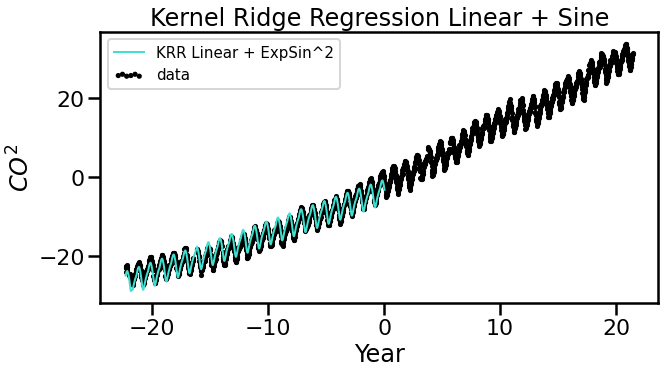

In [117]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.kernel_ridge import KernelRidge
sns.set_context('poster')

kernel = DotProduct() + ExpSineSquared(length_scale=1, periodicity=1)

kr = KernelRidge(alpha = 1e-4,
                 degree = 2,
                 gamma = 1e2,
                 kernel= kernel)


kr.fit(X_train, y_train)

# Predict using kernel ridge on training data
y_kr = kr.predict(X_train)
      
# Plot results
plt.figure(figsize=(10, 5))
lw = 2
plt.scatter(X, y, c='k', label='data', s=10)
plt.plot(X_train, y_kr, color='turquoise', lw=lw,
         label='KRR Linear + ExpSin^2')
plt.xlabel("Year")
plt.ylabel("$CO^2$")
plt.title('Kernel Ridge Regression Linear + Sine')
plt.legend(loc="best",  scatterpoints=6, prop={'size': 15})
plt.show()

# The kernel seems to fit the data well. It is cyclic and follows average increasing trend with slight offest.

### 4. Quadratic + Sine

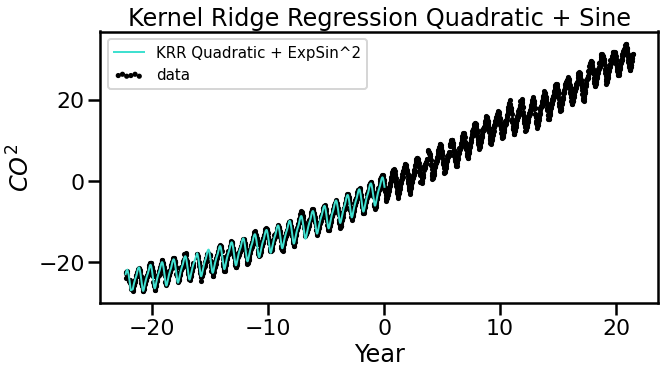

In [118]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.kernel_ridge import KernelRidge
sns.set_context('poster')

kernel = DotProduct()*DotProduct() + ExpSineSquared(length_scale=1, periodicity=1)

kr = KernelRidge(alpha = 1e-4,
                 degree = 2,
                 gamma = 1e2,
                 kernel= kernel)


kr.fit(X_train, y_train)

# Predict using kernel ridge on training data
y_kr = kr.predict(X_train)
      
# Plot results
plt.figure(figsize=(10, 5))
lw = 2
plt.scatter(X, y, c='k', label='data', s=10)
plt.plot(X_train, y_kr, color='turquoise', lw=lw,
         label='KRR Quadratic + ExpSin^2')
plt.xlabel("Year")
plt.ylabel("$CO^2$")
plt.title('Kernel Ridge Regression Quadratic + Sine')
plt.legend(loc="best",  scatterpoints=6, prop={'size': 15})
plt.show()

# The kernel seems to fit the data well. It is cyclic and follows average increasing trend.

### 5. An RBF Kernel with a **large** bandwidth/lengthscale

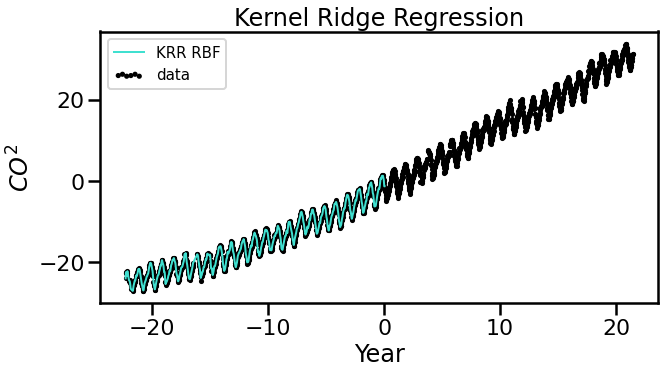

In [119]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.kernel_ridge import KernelRidge
sns.set_context('poster')

# Gamma for bandwith/lengthscale/smoothness
kr = KernelRidge(alpha = 1e-4,
                 gamma = 1e2,
                 kernel= "rbf")

kr.fit(X_train, y_train)

# Predict using kernel ridge on training data
y_kr = kr.predict(X_train)
      
# Plot results
plt.figure(figsize=(10, 5))
lw = 2
plt.scatter(X, y, c='k', label='data', s=10)
plt.plot(X_train, y_kr, color='turquoise', lw=lw,
         label='KRR RBF')
plt.xlabel("Year")
plt.ylabel("$CO^2$")
plt.title('Kernel Ridge Regression')
plt.legend(loc="best",  scatterpoints=6, prop={'size': 15})
plt.show()

# The kernel seems to fit the data well. It is cyclic and follows average increasing trend.

### 6. An RBF Kernel with a **small** bandwidth/lengthscale

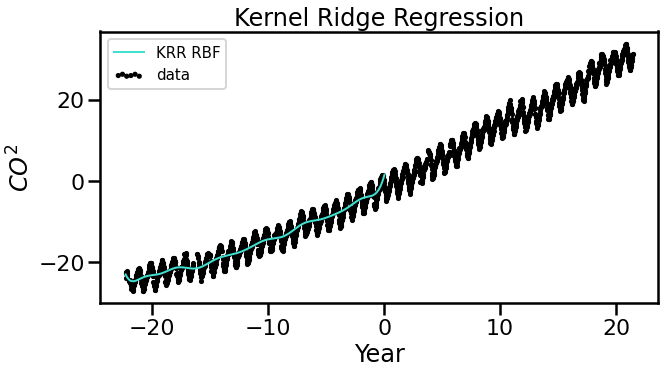

In [120]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.kernel_ridge import KernelRidge
sns.set_context('poster')

# Gamma for bandwith/lengthscale/smoothness
kr = KernelRidge(alpha = 1e-4,
                 gamma = 1e-1,
                 kernel= "rbf")

kr.fit(X_train, y_train)

# Predict using kernel ridge on training data
y_kr = kr.predict(X_train)
      
# Plot results
plt.figure(figsize=(10, 5))
lw = 2
plt.scatter(X, y, c='k', label='data', s=10)
plt.plot(X_train, y_kr, color='turquoise', lw=lw,
         label='KRR RBF')
plt.xlabel("Year")
plt.ylabel("$CO^2$")
plt.title('Kernel Ridge Regression')
plt.legend(loc="best",  scatterpoints=6, prop={'size': 15})
plt.show()

# The kernel seems to fit the data not too well. It follows the increasing trend but not appropriate frequncey or amplitude

### 7. A Matern Kernel with $\nu=2$

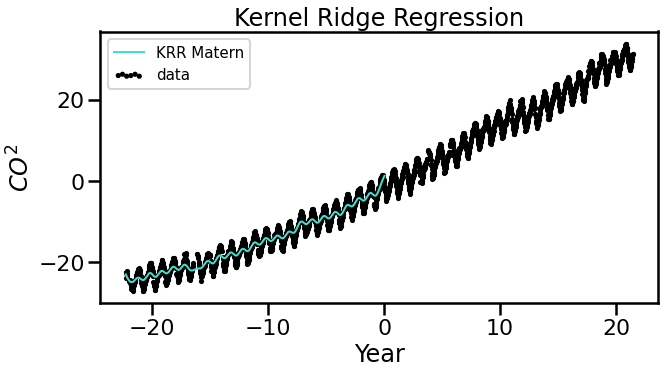

In [121]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.kernel_ridge import KernelRidge
from sklearn.gaussian_process.kernels import Matern
sns.set_context('poster')

#Matern approaches RBF with respect to length_scale and nu. Control of continuity with nu.
kernel = 1.0 * Matern(length_scale=11, nu=2)
 
kr = KernelRidge(alpha = 1e-4,
                 gamma = 1e2,
                 kernel= kernel)

kr.fit(X_train, y_train)

# Predict using kernel ridge on training data
y_kr = kr.predict(X_train)
      
# Plot results
plt.figure(figsize=(10, 5))
lw = 2
plt.scatter(X, y, c='k', label='data', s=10)
plt.plot(X_train, y_kr, color='turquoise', lw=lw,
         label='KRR Matern')
plt.xlabel("Year")
plt.ylabel("$CO^2$")
plt.title('Kernel Ridge Regression')
plt.legend(loc="best",  scatterpoints=6, prop={'size': 15})
plt.show()

# The kernel seems to fit the data not too well. It follows the increasing trend but not appropriate amplitude

### 8. A custom kernel of your own choice/design (can be a single kernel or combinations of them)

C:\Users\GRosp\anaconda3-64\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "


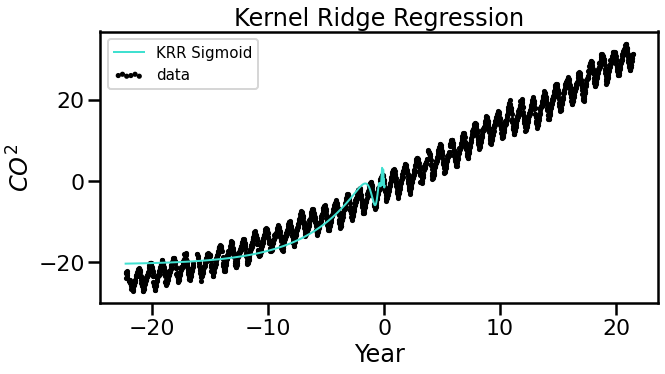

In [122]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.kernel_ridge import KernelRidge
sns.set_context('poster')

kr = KernelRidge(alpha = 1e-4,
                 degree = 2,
                 gamma = 1e2,
                 kernel= 'sigmoid') 

kr.fit(X_train, y_train)

# Predict using kernel ridge on training data
y_kr = kr.predict(X_train)
      
# Plot results
plt.figure(figsize=(10, 5))
lw = 2
plt.scatter(X, y, c='k', label='data', s=10)
plt.plot(X_train, y_kr, color='turquoise', lw=lw,
         label='KRR Sigmoid')
plt.xlabel("Year")
plt.ylabel("$CO^2$")
plt.title('Kernel Ridge Regression')
plt.legend(loc="best",  scatterpoints=6, prop={'size': 15})
plt.show()

# The kernel seems to fit the data not well at all. Does not follow the increasing and cyclical trend 

## Task 2: Extrapolating KRR
Now repeat your analysis of the above, but where we extend the plotting to now cover not only the training data years, but also the test data:

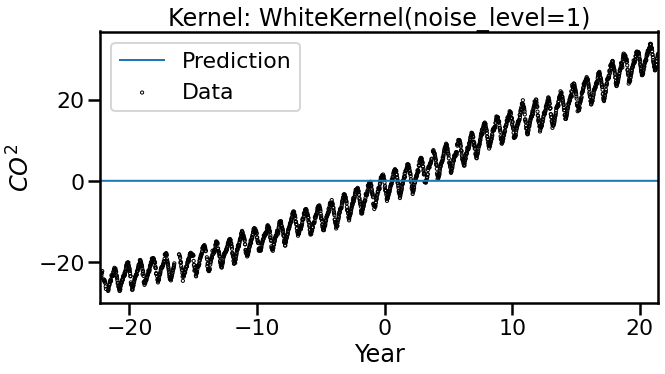

In [123]:
for kernel in kernels_to_plot:
    # Fit Kernel Ridge Regression using the kernels you identified above
    # You can change the default KRR settings below using the parameters listed
    # in the help function above, if you so desire.

    krr = KernelRidge(alpha=1e-8,kernel=kernel)
    krr.fit(X_train, y_train)
    X_predict = np.linspace(X.min(),
                         X.max(), 10000)[:, None]
    y_predict = krr.predict(X_predict)
    
    # Now extrapolate to test data
    plot_CO2_data(X,y,
                  X_predict, y_predict,
                  label = krr.kernel)

## Question 2: 
How, if at all, do your answers to Question 1 change for each of the kernels you used in Question 1? Why do you think this is?

### 1. A Linear kernel 

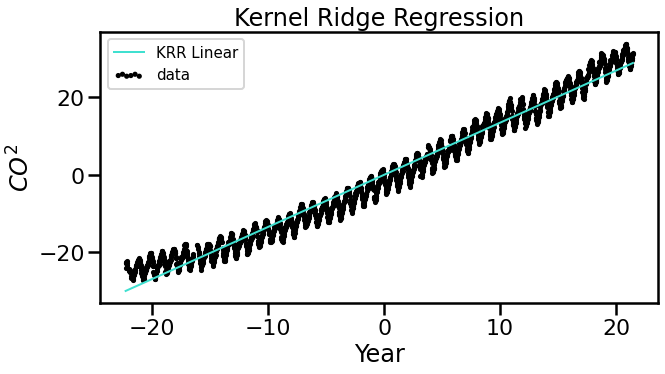

In [124]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.kernel_ridge import KernelRidge
sns.set_context('poster')

kr = KernelRidge(alpha = 1e-4,
                 gamma = 1e2,
                 kernel= "linear") 

kr.fit(X, y)

# Predict using kernel ridge on data
y_kr = kr.predict(X)
      
# Plot results
plt.figure(figsize=(10, 5))
lw = 2
plt.scatter(X, y, c='k', label='data', s=10)
plt.plot(X, y_kr, color='turquoise', lw=lw,
         label='KRR Linear')
plt.xlabel("Year")
plt.ylabel("$CO^2$")
plt.title('Kernel Ridge Regression')
plt.legend(loc="best",  scatterpoints=6, prop={'size': 15})
plt.show()

# Does not change

### 2. A quadratic kernel

C:\Users\GRosp\anaconda3-64\lib\site-packages\sklearn\linear_model\_ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=8.31244e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True,


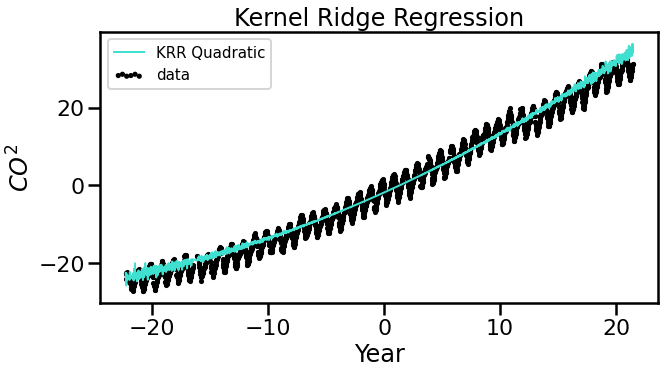

In [125]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.kernel_ridge import KernelRidge
sns.set_context('poster')

kr = KernelRidge(alpha = 1e-4,
                 degree = 2,
                 gamma = 1e2,
                 kernel= 'polynomial') 

kr.fit(X, y)

# Predict using kernel ridge on data
y_kr = kr.predict(X)
      
# Plot results
plt.figure(figsize=(10, 5))
lw = 2
plt.scatter(X, y, c='k', label='data', s=10)
plt.plot(X, y_kr, color='turquoise', lw=lw,
         label='KRR Quadratic')
plt.xlabel("Year")
plt.ylabel("$CO^2$")
plt.title('Kernel Ridge Regression')
plt.legend(loc="best",  scatterpoints=6, prop={'size': 15})
plt.show()

# Does not change however graph is highly altered to be cyclical

### 3. Linear + Sine

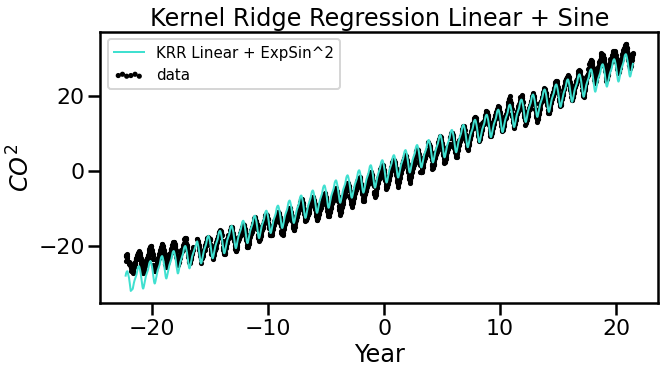

In [132]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.kernel_ridge import KernelRidge
sns.set_context('poster')

kernel = DotProduct() + ExpSineSquared(length_scale=1, periodicity=1)

kr = KernelRidge(alpha = 1e-4,
                 degree = 2,
                 gamma = 1e2,
                 kernel= kernel)


kr.fit(X, y)

# Predict using kernel ridge on data
y_kr = kr.predict(X)
      
# Plot results
plt.figure(figsize=(10, 5))
lw = 2
plt.scatter(X, y, c='k', label='data', s=10)
plt.plot(X, y_kr, color='turquoise', lw=lw,
         label='KRR Linear + ExpSin^2')
plt.xlabel("Year")
plt.ylabel("$CO^2$")
plt.title('Kernel Ridge Regression Linear + Sine')
plt.legend(loc="best",  scatterpoints=6, prop={'size': 15})
plt.show()

# Does change since kernel is much more offset increaing the error of the model

### 4. Quadratic + Sine

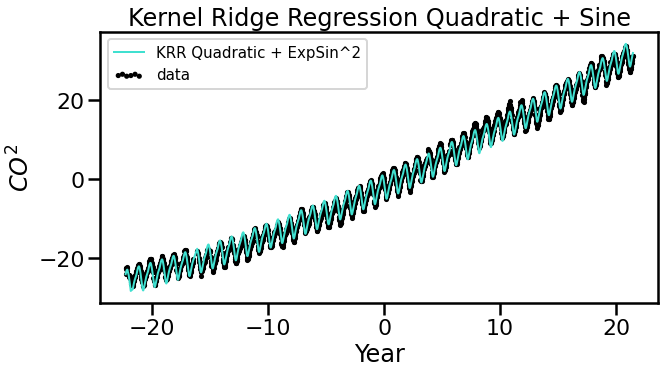

In [127]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.kernel_ridge import KernelRidge
sns.set_context('poster')

kernel = DotProduct()*DotProduct() + ExpSineSquared(length_scale=1, periodicity=1)

kr = KernelRidge(alpha = 1e-4,
                 degree = 2,
                 gamma = 1e2,
                 kernel= kernel)


kr.fit(X, y)

# Predict using kernel ridge on data
y_kr = kr.predict(X)
      
# Plot results
plt.figure(figsize=(10, 5))
lw = 2
plt.scatter(X, y, c='k', label='data', s=10)
plt.plot(X, y_kr, color='turquoise', lw=lw,
         label='KRR Quadratic + ExpSin^2')
plt.xlabel("Year")
plt.ylabel("$CO^2$")
plt.title('Kernel Ridge Regression Quadratic + Sine')
plt.legend(loc="best",  scatterpoints=6, prop={'size': 15})
plt.show()

# Does not change

### 5. An RBF Kernel with a **large** bandwidth/lengthscale

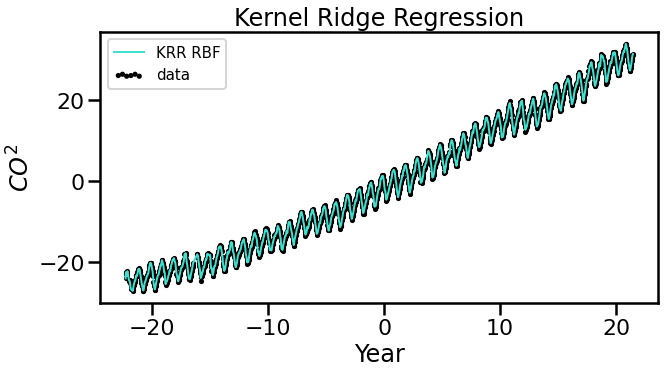

In [128]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.kernel_ridge import KernelRidge
sns.set_context('poster')

# Gamma for bandwith/lengthscale/smoothness
kr = KernelRidge(alpha = 1e-4,
                 gamma = 1e2,
                 kernel= "rbf")

kr.fit(X, y)

# Predict using kernel ridge on data
y_kr = kr.predict(X)
      
# Plot results
plt.figure(figsize=(10, 5))
lw = 2
plt.scatter(X, y, c='k', label='data', s=10)
plt.plot(X, y_kr, color='turquoise', lw=lw,
         label='KRR RBF')
plt.xlabel("Year")
plt.ylabel("$CO^2$")
plt.title('Kernel Ridge Regression')
plt.legend(loc="best",  scatterpoints=6, prop={'size': 15})
plt.show()

# Does not change

### 6. An RBF Kernel with a **small** bandwidth/lengthscale

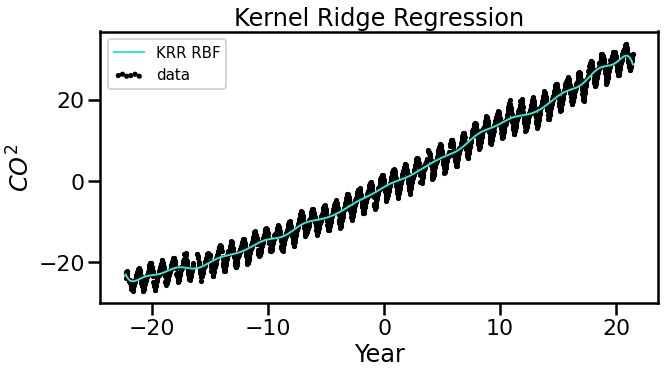

In [129]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.kernel_ridge import KernelRidge
sns.set_context('poster')

# Gamma for bandwith/lengthscale/smoothness
kr = KernelRidge(alpha = 1e-4,
                 gamma = 1e-1,
                 kernel= "rbf")

kr.fit(X, y)

# Predict using kernel ridge on data
y_kr = kr.predict(X)
      
# Plot results
plt.figure(figsize=(10, 5))
lw = 2
plt.scatter(X, y, c='k', label='data', s=10)
plt.plot(X, y_kr, color='turquoise', lw=lw,
         label='KRR RBF')
plt.xlabel("Year")
plt.ylabel("$CO^2$")
plt.title('Kernel Ridge Regression')
plt.legend(loc="best",  scatterpoints=6, prop={'size': 15})
plt.show()

# Does not change

### 7. A Matern Kernel with $\nu=2$

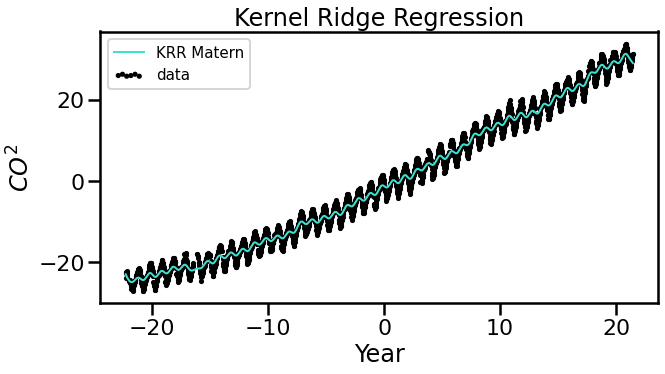

In [130]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.kernel_ridge import KernelRidge
from sklearn.gaussian_process.kernels import Matern
sns.set_context('poster')

#Matern approaches RBF with respect to length_scale and nu. Control of continuity with nu.
kernel = 1.0 * Matern(length_scale=11, nu=2)
 
kr = KernelRidge(alpha = 1e-4,
                 gamma = 1e2,
                 kernel= kernel)

kr.fit(X, y)

# Predict using kernel ridge on data
y_kr = kr.predict(X)
      
# Plot results
plt.figure(figsize=(10, 5))
lw = 2
plt.scatter(X, y, c='k', label='data', s=10)
plt.plot(X, y_kr, color='turquoise', lw=lw,
         label='KRR Matern')
plt.xlabel("Year")
plt.ylabel("$CO^2$")
plt.title('Kernel Ridge Regression')
plt.legend(loc="best",  scatterpoints=6, prop={'size': 15})
plt.show()

# Does not change

### 8. A custom kernel of your own choice/design (can be a single kernel or combinations of them)

C:\Users\GRosp\anaconda3-64\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "


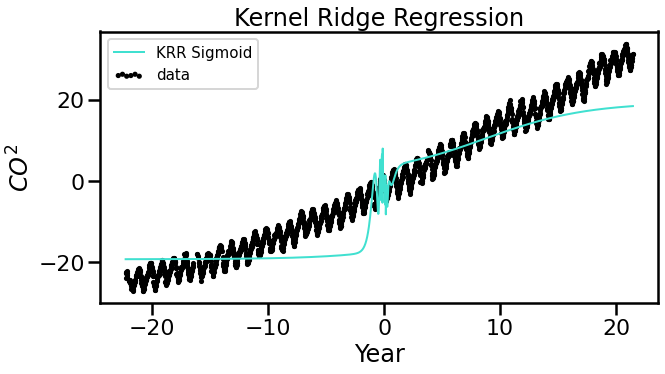

In [131]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.kernel_ridge import KernelRidge
sns.set_context('poster')

kr = KernelRidge(alpha = 1e-4,
                 degree = 2,
                 gamma = 1e2,
                 kernel= 'sigmoid') 

kr.fit(X, y)

# Predict using kernel ridge on data
y_kr = kr.predict(X)
      
# Plot results
plt.figure(figsize=(10, 5))
lw = 2
plt.scatter(X, y, c='k', label='data', s=10)
plt.plot(X, y_kr, color='turquoise', lw=lw,
         label='KRR Sigmoid')
plt.xlabel("Year")
plt.ylabel("$CO^2$")
plt.title('Kernel Ridge Regression')
plt.legend(loc="best",  scatterpoints=6, prop={'size': 15})
plt.show()

# Does not change